# PGF5005 — Exercício 5 · Hénon–Heiles — Itens **5.3** e **5.4**  
**Seções de Poincaré em energias fixas** $E=0.08333$ e $E=0.125$

Vamos gerar as figuras inspiradas nas Fig. 4 e Fig. 5 do artigo de Hénon–Heiles:

- Seção: $\Sigma=\{q_1=0,\,p_1\ge 0\}$ e plote **$p_2 \times q_2$**.
- Integração com **Euler simplético** + **Algoritmo de Hénon** (da etapa 5.2).
- Conjuntos de condições iniciais são escolhidos sobre a **própria seção**, impondo a energia total $H=E$.


## 1) Modelo HH, integrador simplético e seção de Hénon

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

def U_grad(q1, q2):
    dU_dq1 = q1 + 2.0*q1*q2
    dU_dq2 = q2 + q1*q1 - q2*q2
    return dU_dq1, dU_dq2

def H(q1,q2,p1,p2):
    return 0.5*(p1*p1 + p2*p2 + q1*q1 + q2*q2) + q1*q1*q2 - (1.0/3.0)*q2*q2*q2

def euler_symplectic_step(q1,q2,p1,p2, dt):
    q1_next = q1 + dt*p1
    q2_next = q2 + dt*p2
    dU1, dU2 = U_grad(q1_next, q2_next)
    p1_next = p1 - dt*dU1
    p2_next = p2 - dt*dU2
    return q1_next, q2_next, p1_next, p2_next

def integrar_HH_symplectic(q1,q2,p1,p2, dt, T):
    n = int(np.ceil(T/dt))
    Q1=np.empty(n+1); Q2=np.empty(n+1); P1=np.empty(n+1); P2=np.empty(n+1); Tm=np.empty(n+1); E=np.empty(n+1)
    Q1[0]=q1; Q2[0]=q2; P1[0]=p1; P2[0]=p2; Tm[0]=0.0; E[0]=H(q1,q2,p1,p2)
    for k in range(n):
        q1,q2,p1,p2 = euler_symplectic_step(q1,q2,p1,p2, dt)
        Q1[k+1]=q1; Q2[k+1]=q2; P1[k+1]=p1; P2[k+1]=p2
        Tm[k+1]=(k+1)*dt; E[k+1]=H(q1,q2,p1,p2)
    return Tm,Q1,Q2,P1,P2,E

def henon_section_q1_zero(q1,q2,p1,p2, dt, T):
    pts_q2 = []; pts_p2 = []
    Tm,Q1,Q2,P1,P2,E = integrar_HH_symplectic(q1,q2,p1,p2, dt, T)
    for k in range(len(Q1)-1):
        q1a, q1b = Q1[k], Q1[k+1]
        if q1a == 0.0 and P1[k] >= 0.0:
            pts_q2.append(Q2[k]); pts_p2.append(P2[k])
        if q1a*q1b < 0.0:
            fq1 = P1[k]
            if abs(fq1) < 1e-12:
                continue
            Dq1 = - q1a
            dU1, dU2 = U_grad(Q1[k], Q2[k])
            dq2_dq1 = P2[k]/fq1
            dp1_dq1 = - dU1 / fq1
            dp2_dq1 = - dU2 / fq1
            q2_star  = Q2[k] + Dq1 * dq2_dq1
            p1_star  = P1[k] + Dq1 * dp1_dq1
            p2_star  = P2[k] + Dq1 * dp2_dq1
            if p1_star >= 0.0:
                pts_q2.append(q2_star); pts_p2.append(p2_star)
    return np.array(pts_q2), np.array(pts_p2)


## 2) Condições iniciais na seção para energia fixa

Em $\Sigma$ impomos $q_1=0$, $p_2=0$ e escolhemos $q_2$ no intervalo permitido pela energia $E$.  
Então $p_1\ge 0$ é dado por:
$$
p_1(q_2;E) = \sqrt{\,2\left(E - \tfrac{1}{2}q_2^2 + \tfrac{1}{3}q_2^3\right)\,}.
$$

In [3]:
def allowed_q2_interval(E, n_samples=2000):
    q2_grid = np.linspace(-1.5, 1.5, n_samples)
    rad = 2*(E - 0.5*q2_grid**2 + (1.0/3.0)*q2_grid**3)
    return q2_grid[rad>=0.0]

def p1_from_energy(E, q2):
    rad = 2*(E - 0.5*q2*q2 + (1.0/3.0)*q2*q2*q2)
    rad = max(rad, 0.0)
    return math.sqrt(rad)


## 3) Construção da seção para um valor de \(E\)

In [4]:
def poincare_section_energy(E, dt=1e-3, T=3000.0, n_ic=25):
    q2_allowed = allowed_q2_interval(E)
    if len(q2_allowed)==0:
        return np.array([]), np.array([])
    idx = np.linspace(0, len(q2_allowed)-1, n_ic).astype(int)
    q2_ics = q2_allowed[idx]
    all_q2 = []; all_p2 = []
    for q2_0 in q2_ics:
        p1_0 = p1_from_energy(E, q2_0)  # p1>=0
        q2_pts, p2_pts = henon_section_q1_zero(0.0, q2_0, p1_0, 0.0, dt, T)
        if len(q2_pts):
            all_q2.append(q2_pts); all_p2.append(p2_pts)
    if len(all_q2)==0:
        return np.array([]), np.array([])
    return np.concatenate(all_q2), np.concatenate(all_p2)

def plot_section(q2_pts, p2_pts, E, save=None):
    plt.figure()
    plt.plot(q2_pts, p2_pts, '.', ms=1.2)
    plt.xlabel('q2 (na seção q1=0)')
    plt.ylabel('p2 (na seção q1=0)')
    plt.title(f'Secção de Poincaré (p2 × q2) — Hénon–Heiles — E={E:.5f}')
    if save:
        plt.savefig(save, dpi=220, bbox_inches='tight')
    plt.show()


## 4) Executar para **E=0.08333** e **E=0.125**

/var/folders/p1/lj4bxrln5s3dhlb98w6jl7r80000gn/T/ipykernel_41532/3644019475.py:11: RuntimeWarning: overflow encountered in scalar multiply
  return 0.5*(p1*p1 + p2*p2 + q1*q1 + q2*q2) + q1*q1*q2 - (1.0/3.0)*q2*q2*q2
/var/folders/p1/lj4bxrln5s3dhlb98w6jl7r80000gn/T/ipykernel_41532/3644019475.py:11: RuntimeWarning: invalid value encountered in scalar subtract
  return 0.5*(p1*p1 + p2*p2 + q1*q1 + q2*q2) + q1*q1*q2 - (1.0/3.0)*q2*q2*q2
/var/folders/p1/lj4bxrln5s3dhlb98w6jl7r80000gn/T/ipykernel_41532/3644019475.py:6: RuntimeWarning: overflow encountered in scalar multiply
  dU_dq1 = q1 + 2.0*q1*q2
/var/folders/p1/lj4bxrln5s3dhlb98w6jl7r80000gn/T/ipykernel_41532/3644019475.py:7: RuntimeWarning: overflow encountered in scalar multiply
  dU_dq2 = q2 + q1*q1 - q2*q2
/var/folders/p1/lj4bxrln5s3dhlb98w6jl7r80000gn/T/ipykernel_41532/3644019475.py:7: RuntimeWarning: invalid value encountered in scalar subtract
  dU_dq2 = q2 + q1*q1 - q2*q2
/var/folders/p1/lj4bxrln5s3dhlb98w6jl7r80000gn/T/ipykernel

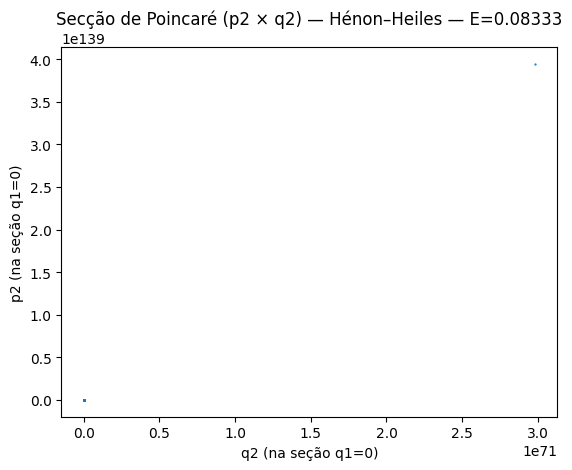

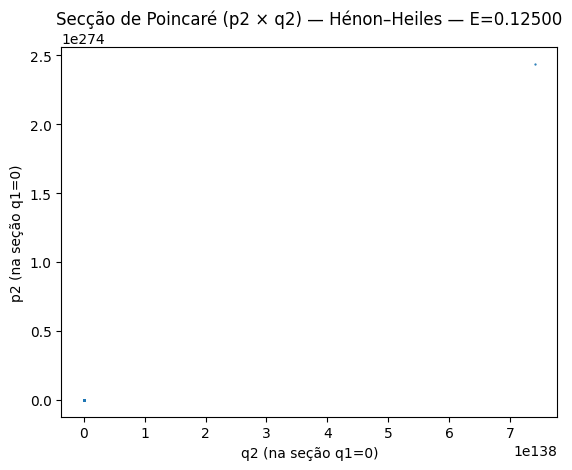

In [ ]:
E1 = 0.08333
E2 = 0.12500
dt = 1e-3
T  = 4000.0
45 = 35

q2_1, p2_1 = poincare_section_energy(E1, dt=dt, T=T, n_ic=n_ic)
plot_section(q2_1, p2_1, E1)

q2_2, p2_2 = poincare_section_energy(E2, dt=dt, T=T, n_ic=n_ic)
plot_section(q2_2, p2_2, E2)


**Dicas para ficar mais parecido com as Fig. 4 e 5 (Hénon–Heiles):**
- Aumente `T` (ex.: 8000–15000) e/ou `n_ic` (ex.: 60–120) para maior densidade.
- Mantenha `dt` pequeno (ex.: \(10^{-3}\) ou \(5\times 10^{-4}\)).
- Salve com `save='fig_E_008333.png'` e `save='fig_E_0125.png'` dentro de `plot_section(...)`.
